In [2]:
import pandas as pd
import numpy as np

In [3]:
vxm1 = pd.read_csv(
    "/mnt/c/Users/ben/Desktop/afts/vix1.csv", index_col="index", parse_dates=["index"]
).fillna(method="ffill")
vxm2 = pd.read_csv(
    "/mnt/c/Users/ben/Desktop/afts/vix2.csv", index_col="index", parse_dates=["index"]
).fillna(method="ffill")
vxm3 = pd.read_csv(
    "/mnt/c/Users/ben/Desktop/afts/vix3.csv", index_col="index", parse_dates=["index"]
).fillna(method="ffill")

vx = pd.merge(vxm1["underlying"], vxm2["underlying"], left_index=True, right_index=True)
vx = pd.merge(vx, vxm3["underlying"], left_index=True, right_index=True)
vx.columns = ["vxm1", "vxm2", "vxm3"]
vx

,vxm1,vxm2,vxm3
index,,,
2006-11-13,12.68,13.17,13.70
2006-11-14,12.54,13.06,13.65
2006-11-15,12.35,12.93,13.54
2006-11-16,12.29,12.90,13.38
2006-11-17,12.32,12.94,13.44
...,...,...,...
2022-10-28,26.90,28.00,28.10
2022-10-31,26.50,27.70,27.90
2022-11-01,26.15,27.35,27.55


In [4]:
# Create a custom business day to consider only weekdays as trading days
custom_business_day = pd.offsets.CustomBusinessDay(weekmask="Mon Tue Wed Thu Fri")

# Create a pandas date range from '2006-11-13' to today using the custom business day frequency
start_date = pd.to_datetime("2006-11-13")
end_date = pd.to_datetime("today")
date_series = pd.date_range(start=start_date, end=end_date, freq=custom_business_day)

# Convert the date series into a DataFrame with a proper column name
df = pd.DataFrame({"Date": date_series})

# Find the last trading day of the month for each date
df["last_trading_day"] = df["Date"] + pd.offsets.MonthEnd(0)

# Calculate the difference in days until the front month VIX expiry, considering only weekdays
df["days_until_expiry"] = (df["last_trading_day"] - df["Date"]).dt.days

# Drop the 'last_trading_day' column if you don't need it
df.drop(columns=["last_trading_day"], inplace=True)

# Set the 'Date' column as the index to create the final DataFrame
df.set_index("Date", inplace=True)

# The result is now a DataFrame with the index being the date and 'days_until_expiry' as the corresponding value.
result_df = df

df

,days_until_expiry
Date,
2006-11-13,17
2006-11-14,16
2006-11-15,15
2006-11-16,14
2006-11-17,13
...,...
2023-08-16,15
2023-08-17,14
2023-08-18,13


In [8]:
df = df.loc[vx.index]
vx30 = vx["vxm1"] + ((vx["vxm2"] - vx["vxm1"]) / (df["days_until_expiry"] + 30)) * df["days_until_expiry"]
vx30

index
2006-11-13    12.857234
2006-11-14    12.720870
2006-11-15    12.543333
2006-11-16    12.484091
2006-11-17    12.507442
                ...    
2022-10-28    27.000000
2022-10-31    26.500000
2022-11-01    26.739831
2022-11-02    27.155172
2022-11-03    27.394737
Length: 4169, dtype: float64

In [58]:
import yfinance as yf

vix = yf.download('^VIX', start='2006-11-13', end='2022-11-03')['Adj Close']
vix_basis = vx30 - vix
#vix_basis.plot(figsize=(10, 6), title='VIX Basis', grid=True, legend=True);
print(vix_basis.describe())
print(vix_basis.skew())
print(vix_basis.kurtosis())
print(vix_basis)


[*********************100%***********************]  1 of 1 completed
count    4021.000000
mean       20.210761
std         9.377283
min         9.140000
25%        13.830000
50%        17.670000
75%        23.660000
max        82.690002
Name: Adj Close, dtype: float64
-4.083930791460034
27.514577092576758
2006-11-13    1.997234
2006-11-14    2.220870
2006-11-15    2.233333
2006-11-16    2.324091
2006-11-17    2.457442
                ...   
2022-10-28    1.250000
2022-10-31    0.620001
2022-11-01    0.929831
2022-11-02    1.295172
2022-11-03         NaN
Length: 4169, dtype: float64


[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'VIX Basis Strategy Returns'}>

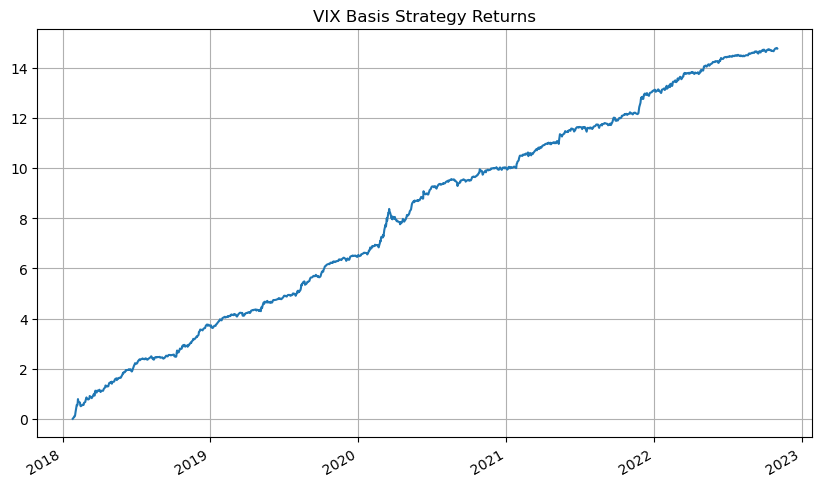

In [53]:
vxx = yf.download("VXX", start="2006-11-13", end="2022-11-03")['Adj Close']
vxx_returns = np.log(vxx / vxx.shift(1)).dropna()
vix_basis_rule = vix_basis.apply(np.sign) * -1
vix_basis_returns = vix_basis_rule * vxx_returns
vix_basis_returns.dropna().cumsum().plot(figsize=(10, 6), title='VIX Basis Strategy Returns', grid=True)


4.272832171801677
1.0183274622818097


<Axes: >

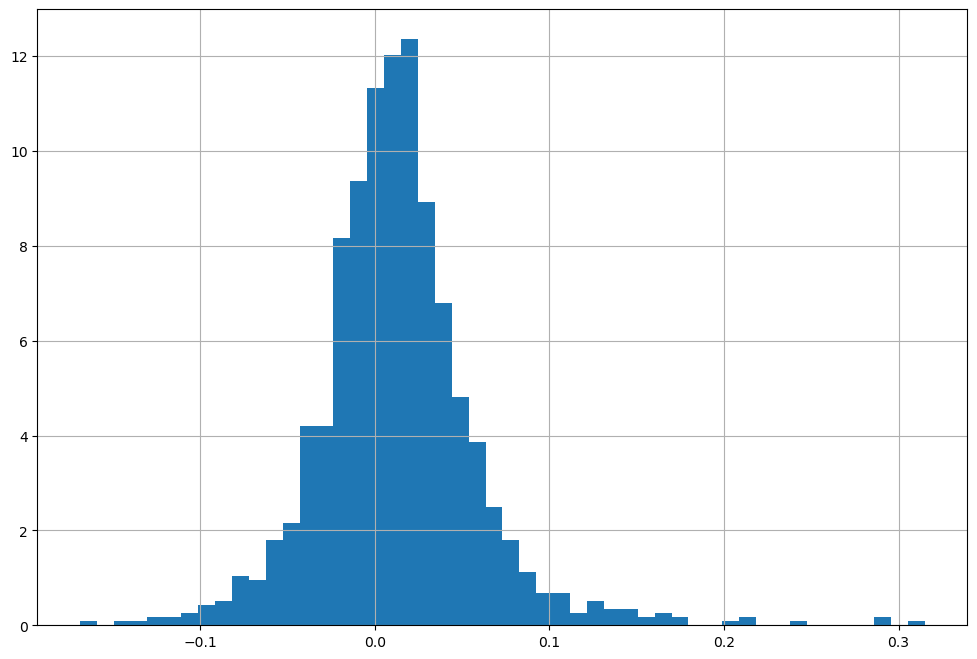

In [57]:
print(vix_basis_returns.mean() / vix_basis_returns.std() * np.sqrt(252))
print(vix_basis_returns.skew())
vix_basis_returns.hist(bins=50, figsize=(12, 8), density=True)